In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Boosting!
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict
pd.options.mode.chained_assignment = None

In [2]:
%run ../common_utils.py

In [3]:
def handout_RMSLE(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## 1 - First test of XGBOOST: *eXtreme Gradient Boosting*
Just getting it to work. Understand the hyperparameters.

Tip from Hasse: you can use reg:squaredlogerror as objective and rsmle as eval_metric for the xgboost model

Unlike CatBoost or LGBM, XGBoost cannot handle categorical features by itself, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, mean encoding or one-hot encoding before supplying categorical data to XGBoost.

The magic of XGBoost: handles nan values! As long as nan is distributed the same across both train and test: ez pz!

Good sources;
- https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
- https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase
- https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression
- https://analyticsindiamag.com/how-to-use-xgboost-to-predict-housing-prices-in-bengaluru-a-practical-guide/


In [10]:
train, test, metaData = load_all_data()
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction

In [219]:
## Remove some of the ones correlated to themselves.
#features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
#                    "district", "material", "parking"] 
#
#numerical_features = ["area_total", "area_kitchen", "area_living",
#                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]
#
#cat_features = ["district", "material", "parking"]
#
#droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

# ALL
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating"]

droptable = ['longitude', 'latitude']

In [220]:
# Remove outlayers from training data
outliers_value = 7
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

# Not filling nan!
# Training and validation data preprocessing
labels = no_outlayers[features]
targets = no_outlayers['price']
# Skew normaliation
labels[numerical_features] = np.log1p(labels[numerical_features])

# Test data preprocessing
test_labels = test[features]
# Skew normaliation
test_labels[numerical_features] = np.log1p(test_labels[numerical_features])

In [221]:
# One-hot encoding categorical features.
#labels, test_labels = one_hot_encoder(labels, test_labels, cat_features, drop_old=drop_old)
#NB! pd.get_dummies() does pretty much the same job!
#https://stackoverflow.com/questions/36285155/pandas-get-dummies

labels = pd.get_dummies(labels,columns=cat_features)
test_labels = pd.get_dummies(test_labels,columns =cat_features)

In [222]:
# ADD R
labels, test_labels = polar_coordinates(labels, test_labels)
numerical_features.append("r")
# ADD rel_height
labels['rel_height'] = labels["floor"] / labels["stories"]
test_labels['rel_height'] = test_labels["floor"] / test_labels["stories"]
numerical_features.append("rel_height")

In [223]:
# Normalize
train_labels_n = labels.filter(numerical_features)
test_labels_n = test_labels.filter(numerical_features)

scaler = MinMaxScaler(feature_range=(0, 1))
train_labels_scaled = scaler.fit_transform(train_labels_n)
test_labels_scaled = scaler.transform(test_labels_n)

# Re-enter proceedure
training_norm_col = pd.DataFrame(train_labels_scaled, index=train_labels_n.index, columns=train_labels_n.columns) 
labels.update(training_norm_col)

testing_norm_col = pd.DataFrame(test_labels_scaled, index=test_labels_n.index, columns=test_labels_n.columns) 
test_labels.update(testing_norm_col)

### Looking for most relevant features

In [224]:
model = xgboost.XGBRegressor(
                 colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42
                )

In [120]:
# Convert all nan to "nan"?
features_with_nan = labels.columns[labels.isna().any()].tolist() # Same for train and test
#def ConverNaNToNAString(data, columnList):
#    for x in columnList:    
#        data[x] =str(data[x])
#
#ConverNaNToNAString(labels, features_with_nan)
#ConverNaNToNAString(test_labels, features_with_nan)

In [121]:
model.fit(labels,targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [122]:
#OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

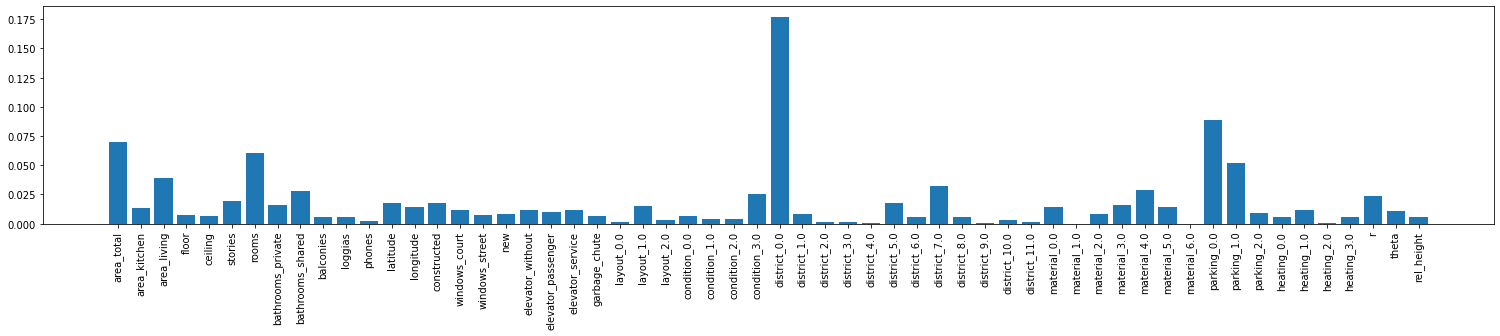

In [123]:
plt.figure(figsize=(26, 4))
plt.bar(labels.columns.tolist(), model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Remove less relevant features

In [124]:
# r : 0.022947283 
importance = dict(zip(labels.columns.tolist(), 
model.feature_importances_))

important_features = []
for key in importance.keys():
    if importance[key] > 0.01:
        important_features.append(key)
print(important_features)

['area_total', 'area_kitchen', 'area_living', 'stories', 'rooms', 'bathrooms_private', 'bathrooms_shared', 'latitude', 'longitude', 'constructed', 'windows_court', 'elevator_without', 'elevator_service', 'layout_1.0', 'condition_3.0', 'district_0.0', 'district_5.0', 'district_7.0', 'material_0.0', 'material_3.0', 'material_4.0', 'material_5.0', 'parking_0.0', 'parking_1.0', 'heating_1.0', 'r', 'theta']


In [126]:
labels = labels[important_features]
test_labels = test_labels[important_features]

### CUSTOM RMSLE OBJECTIVE
https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html

In [225]:
from typing import Tuple
def gradient(predt: np.ndarray, dtrain: xgboost.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgboost.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
    np.power(predt + 1, 2))

def squared_log(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Squared Log Error objective. A simplified version for RMSLE used as objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [196]:
def rmsle_metric(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

### Training 

In [253]:
# 
train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.33, shuffle=True)

xgb_model = xgboost.XGBRegressor(eval_metric="rmsle")

smt = xgb_model.fit(train_labels, train_targets, eval_set=[(train_labels, train_targets), (val_labels, val_targets)], early_stopping_rounds=10, verbose=False)

In [254]:
xgb_prediction = xgb_model.predict(val_labels)
xgb_rmsle = handout_RMSLE(val_targets, xgb_prediction)
print('XGBoost RMSLE:', xgb_rmsle)

XGBoost RMSLE: 0.18702611509417402


In [255]:
results = xgb_model.evals_result()

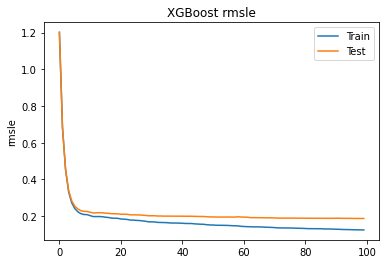

In [259]:
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
# plot rmsle
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylabel('rmsle')
plt.title('XGBoost rmsle')
plt.show()

In [260]:
predict_and_store(xgb_model, test_labels, test, path="boosting_predictions/xgboost_0_1") # 0.18702611509417402

### Train on all features.

In [96]:
%run ../common_utils.py

In [97]:
# ALL
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

In [98]:
train_labels, train_targets, val_labels, val_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=True, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True)

In [99]:
xgb_model = xgboost.XGBRegressor(eval_metric="rmsle")
xgb_model.fit(train_labels, train_targets, eval_set=[(train_labels, train_targets), (val_labels, val_targets)], early_stopping_rounds=10, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [100]:
xgb_prediction = xgb_model.predict(val_labels)
xgb_rmsle = handout_RMSLE(val_targets, xgb_prediction)
print('XGBoost RMSLE:', xgb_rmsle)

XGBoost RMSLE: 0.1938091472595307


In [101]:
results = xgb_model.evals_result()

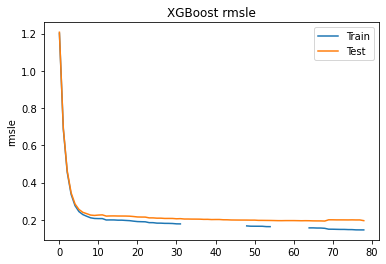

In [102]:
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
# plot rmsle
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylabel('rmsle')
plt.title('XGBoost rmsle')
plt.show()

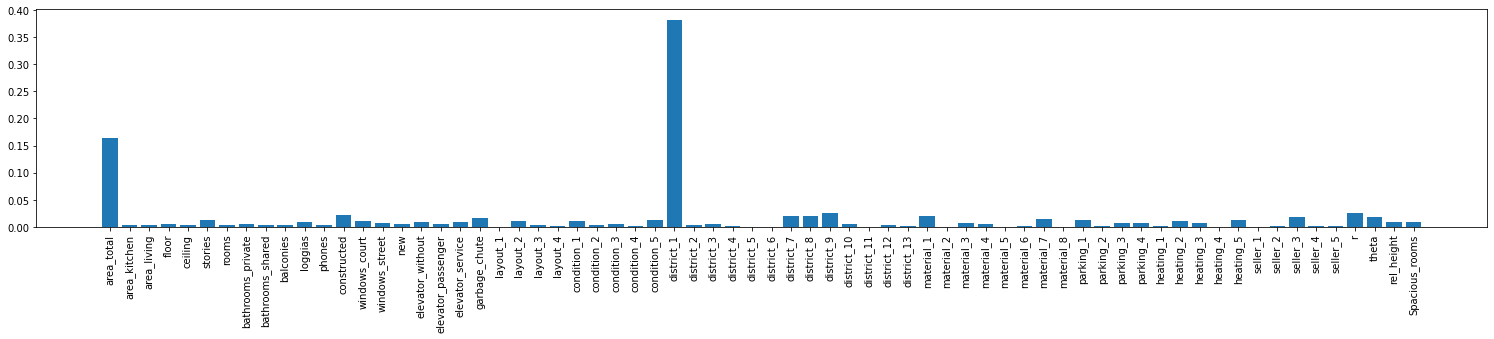

In [103]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), xgb_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [104]:
#predict_and_store(xgb_model, test_labels, test, path="boosting_predictions/xgboost_1_0") #0.17482169125398114

In [105]:
importance = dict(zip(train_labels.columns.tolist(), xgb_model.feature_importances_))

important_features = []
for key in importance.keys():
    if importance[key] > 0.005:
        important_features.append(key)

In [106]:
train_labels = train_labels[important_features]
test_labels = test_labels[important_features]
val_labels = val_labels[important_features]

In [114]:
xgb_model_2 = xgboost.XGBRegressor(eval_metric="rmsle")
xgb_model_2.fit(train_labels, train_targets, eval_set=[(train_labels, train_targets), (val_labels, val_targets)], early_stopping_rounds=10, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [115]:
results = xgb_model_2.evals_result()
xgb_prediction = xgb_model_2.predict(val_labels)
xgb_rmsle = handout_RMSLE(val_targets, xgb_prediction)
print('XGBoost RMSLE:', xgb_rmsle)
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

XGBoost RMSLE: 0.18889299183479616


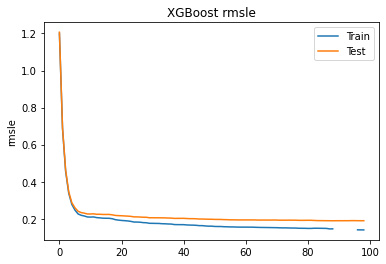

In [116]:
# plot rmsle
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylabel('rmsle')
plt.title('XGBoost rmsle')
plt.show()

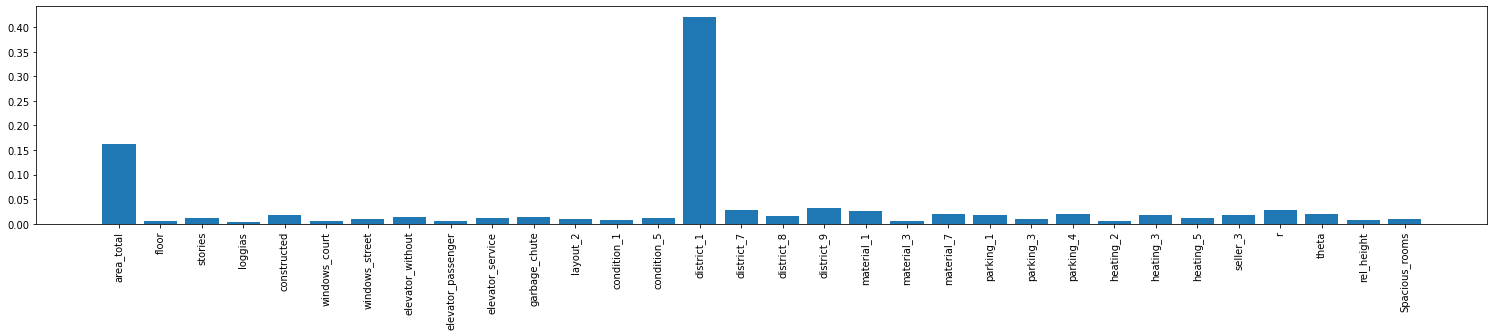

In [117]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), xgb_model_2.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [119]:
predict_and_store(xgb_model_2, test_labels, test, path="boosting_predictions/xgboost_1_1") # removing some features 0.18889299183479616 

In [120]:
## Without early stop
xgb_model_3 = xgboost.XGBRegressor(eval_metric="rmsle")
xgb_model_3.fit(train_labels, train_targets, eval_set=[(train_labels, train_targets), (val_labels, val_targets)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [121]:
results = xgb_model_3.evals_result()
xgb_prediction = xgb_model_3.predict(val_labels)
xgb_rmsle = handout_RMSLE(val_targets, xgb_prediction)
print('XGBoost RMSLE:', xgb_rmsle)
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

XGBoost RMSLE: 0.18908033067070468


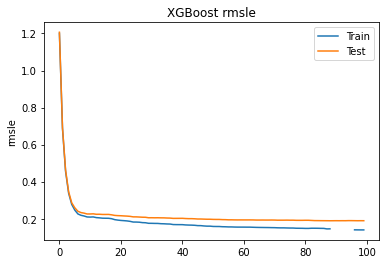

In [122]:
# plot rmsle
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylabel('rmsle')
plt.title('XGBoost rmsle')
plt.show()

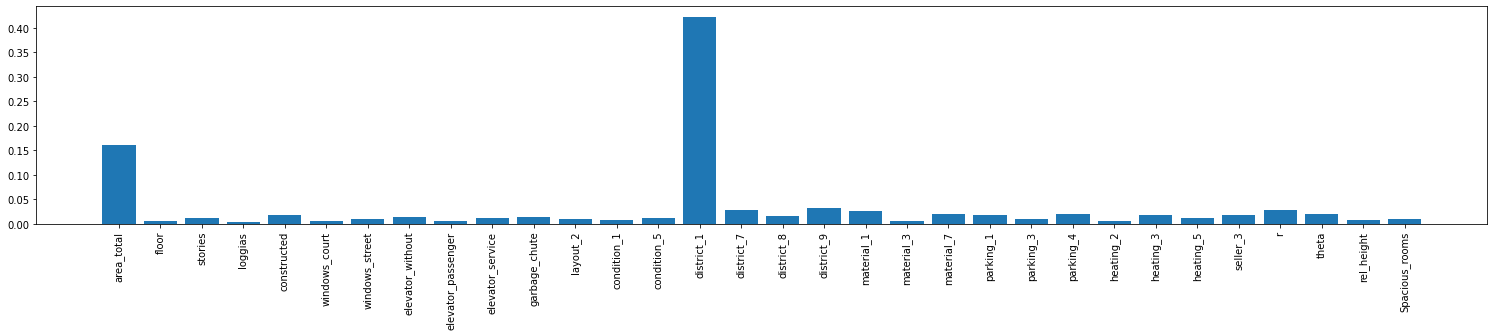

In [124]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), xgb_model_3.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [126]:
predict_and_store(xgb_model_3, test_labels, test, path="boosting_predictions/xgboost_1_2") # Remove ealry stopping? Still stopped early..?

### Grouped validation

In [170]:
%run ../common_utils.py

In [171]:
# ALL, and building ID!
features =           ["building_id", "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

In [172]:
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True)

In [173]:
xgb_model = xgboost.XGBRegressor(eval_metric="rmsle")

In [174]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, np.log(train_targets),
    eval_metric='rmsle')

In [175]:
print(scores)
print("=>",avg)

[0.2173668035170326, 0.22084274126952558, 0.19567189829890033, 0.2254769135547558, 0.22879392874440108]
=> 0.2176304570769231


### Train again, removing less important features

In [176]:
# remove less important features
importance = dict(zip(train_labels.columns.tolist(), best_model.feature_importances_))

In [177]:
important_features = []
for key in importance.keys():
    if importance[key] > 0.005:
        important_features.append(key)
important_features.append("building_id")

In [178]:
train_labels = train_labels[important_features]
test_labels = test_labels[important_features]

In [179]:
xgb_model = xgboost.XGBRegressor()

In [180]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, np.log(train_targets),
    eval_metric='rmsle')

In [181]:
print(scores)
print("=>",avg)

[0.2300635842928966, 0.2147728723163454, 0.19870266770789563, 0.222449935363716, 0.25161717595296035]
=> 0.22352124712676277


### Instead of one-hot, just keep numerical encoding!

In [183]:
%run ../common_utils.py

In [184]:
# ALL, and building ID!
features =           ["building_id", "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

In [185]:
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True) # FALSE!

In [186]:
xgb_model = xgboost.XGBRegressor()

In [187]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, np.log(train_targets),
    eval_metric='rmsle')

In [188]:
print(scores)
print("=>",avg)

[0.21809380864569033, 0.2215233953756159, 0.19050211303649378, 0.20765674423950248, 0.24716529027741654]
=> 0.2169882703149438


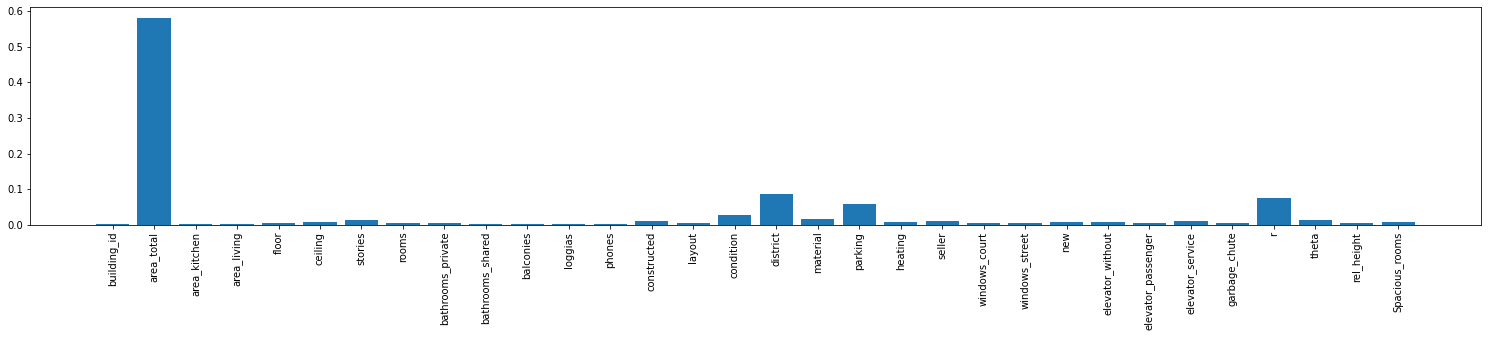

In [189]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [191]:
# Remove most features
important_features = ["building_id", "area_total", "condition", "district", "material", "parking", "r"]
train_labels = train_labels[important_features]
test_labels = test_labels[important_features]

In [192]:
xgb_model = xgboost.XGBRegressor()

In [193]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, np.log(train_targets),
    eval_metric='rmsle')
print(scores)
print("=>",avg)

[0.22491496629761598, 0.23427090637392414, 0.22401013112338758, 0.2332019822090892, 0.2698426529090872]
=> 0.23724812778262078


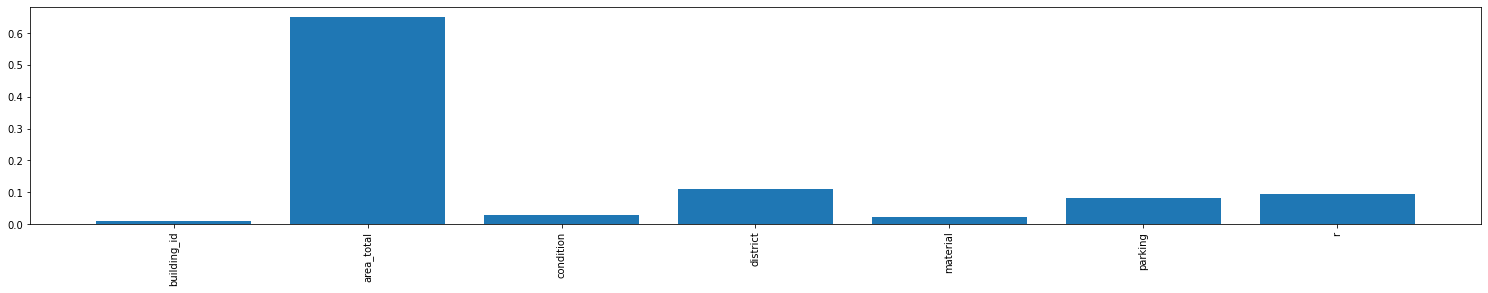

In [194]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Hyperparameter tuning
1. What we have learned: One-hot gives pretty much same score as just numerical encoding. Ordinality seems useless for this method.
2. Using more features is almost always better.

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [199]:
%run ../common_utils.py
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True)

In [218]:
#parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3, 10, 5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
#}

In [246]:
xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3) #learning_rate=0.01, n_estimators=10000

parameters_for_testing = {
    #'min_child_weight':[12, 13, 14, 15, 16, 17, 18, 19, 20], #
    #'max_depth':[3, 4, 5, 6],
    #'subsample':[0.78,0.8, 0.83],  # – Subsample ratio of the training instance
    #'colsample_bytree':[0.78,0.8, 0.83], #– Subsample ratio of columns when constructing each tree
    #'gamma':[0, 0.01, 0.05, 0.1, 0.15, 0.2], # -Minimum loss reduction required to make a further partition on a leaf node of the tree
    #'learning_rate':[0.01, 0.05, 0.1, 0.15],
    #'n_estimators':[200, 500, 10000, 5000],
    #'reg_alpha':[0.9, 1, 1.1, 1.2],
    #'reg_lambda':[0.3, 0.35, 0.4, 0.45, 0.5],
}

gsearch1 = GridSearchCV(
    estimator=xgb_model, 
    param_grid=parameters_for_testing, 
    cv=5, verbose=10, 
    n_jobs=-1, 
    scoring="neg_mean_squared_error",
    #early_stopping_rounds=10
)

In [247]:
fit = gsearch1.fit(train_labels, np.log(train_targets)) #NB! logging to get ms(l)e

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [248]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'reg_lambda': 0.3}
best score
-0.057519258075576195


-----------------------------------------
#1
'min_child_weight':[1,6,10], -> 10
'max_depth':[5,10,30], -> 5
#2
'min_child_weight':[9, 10, 11, 12], -> 12
'max_depth':[3, 4, 5, 6], -> 5!
#3
'min_child_weight':[12, 13, 14, 15, 16, 17, 18, 19, 20] -> 12!
-----------------------------------------
#1
'subsample':[0.6, 0.7,0.8,0.9],  -> 0.8
'colsample_bytree':[0.6, 0.7,0.8,0.9], -> 0.8
#2
'subsample':[0.78,0.8, 0.83], -> 0.8!
'colsample_bytree':[0.78,0.8, 0.83], -> 0.8!
-----------------------------------------
#1
'gamma':[0, 0.01, 0.05, 0.1, 0.15, 0.2], -> 0.15
-----------------------------------------
#1
'learning_rate':[0.01, 0.05, 0.1, 0.15], -> 0.01
'n_estimators':[200, 500, 10000, 5000], -> 10000
-----------------------------------------
#1
'reg_alpha':[1e-5, 1e-2,  0.75], -> 0.75
'reg_lambda':[1e-5, 1e-2, 0.45], -> 0.01

#2
'reg_alpha':[0.1, 0.4, 0.75, 0.9], -> 0.9
'reg_lambda':[0.005, 1e-2, 0.1, 0.15], -> 0.15

#3
'reg_alpha':[0.9, 1, 1.1, 1.2], ->1.1
'reg_lambda':[0.15, 0.2, 0.25, 0.3], -> 0.3

#4
'reg_lambda':[0.3, 0.35, 0.4, 0.45, 0.5], -> 0.3

### Now test these "best" parameters

In [35]:
%run ../common_utils.py

In [36]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

In [37]:
train, test, metaData = load_all_data()

In [38]:
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True) # FALSE!

In [39]:
# The seperately tuned model.
xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [40]:
# We are passing targets as log, as we dont have a rmsle loss, only an rmse
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, np.log(train_targets),
    eval_metric='rmse')

In [41]:
print(scores)
print("=>",avg)

[0.20997854778572503, 0.20411401428401665, 0.1810377837518819, 0.20409205016570606, 0.23974537130488005]
=> 0.20779355345844194


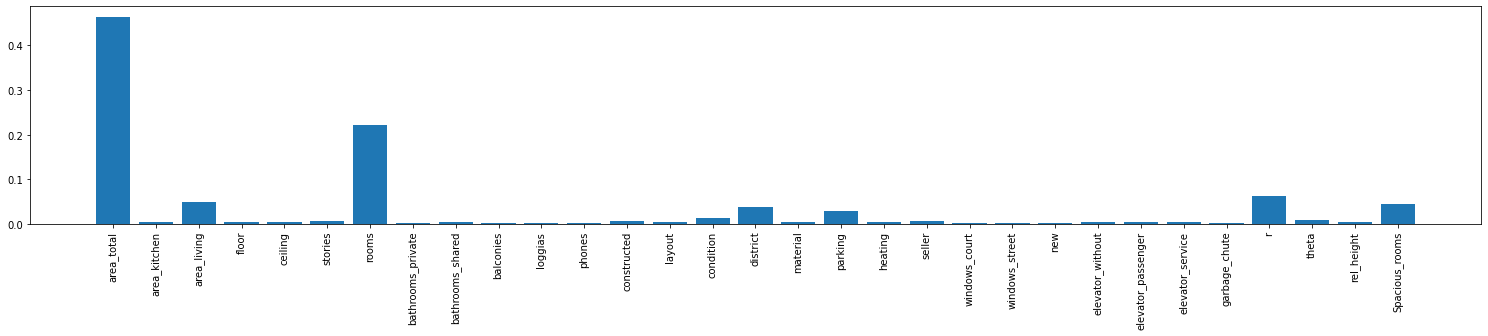

In [43]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [46]:
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/hypertuned_1_1", exponential=True)

In [21]:
# For hypertuned_1_0: Using hypertuned parameters, on all features, just using categorical data as is (numeical that is)
# For hypertuned_1_1: metric rmse was used instead of rmsle as we pass log(y) as target, and also! Drop "buildig_id" after grouping

### Hyperparameter tuning on all at the same time! Night-time run...

In [52]:
train, test, metaData = load_all_data()

In [53]:
%run ../common_utils.py
train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True)

minMax


In [54]:
xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

parameters_for_testing = {
    'min_child_weight':[11, 12, 13], #
    'max_depth':[4, 5, 6],
    'subsample':[0.7,0.8, 0.9],  # – Subsample ratio of the training instance
    'colsample_bytree':[0.7,0.8, 0.9], #– Subsample ratio of columns when constructing each tree
    'gamma':[0.1, 0.15, 0.2], # -Minimum loss reduction required to make a further partition on a leaf node of the tree
    'learning_rate':[0.01, 0.1, 0.2],
    'n_estimators':[500, 1000, 5000],
    'reg_alpha':[0.9, 1.1, 1.3],
    'reg_lambda':[0.1, 0.3, 0.5],
}

gsearch1 = GridSearchCV(
    estimator=xgb_model, 
    param_grid=parameters_for_testing, 
    cv=5, verbose=10, 
    n_jobs=-1, 
    scoring="neg_mean_squared_error",
)

In [ ]:
fit = gsearch1.fit(train_labels, np.log(train_targets)) #NB! logging to get ms(l)e

Fitting 5 folds for each of 19683 candidates, totalling 98415 fits


In [ ]:
print('best params')
print (gsearch1.best_params_)
print('best score')

print (gsearch1.best_score_)

### Experiment with the new fillnans


In [62]:
%run ../common_utils.py

In [63]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones", "constructed"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal cat features

droptable = ['longitude', 'latitude']

In [64]:
train, test, metaData = load_all_data()

In [65]:
train_labels, train_targets, test_labels = pre_process_2(train, test, 
                    features, float_numerical_features, int_numerical_features, cat_features, 
                    metadata=[], scaler="minMax", 
                    common_mean=True, professor_laures_fillna=True, 
                    log_it=["area_total", "area_living", "area_kitchen"], log_target=True,
                    add_R=True, add_rel_height=True, add_spacious=True,
                    droptable=[], one_hot_encode=False, drop_old=True)

minMax


In [66]:
# The seperately tuned model.
xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [67]:
# We are passing targets as log, as we dont have a rmsle loss, only an rmse
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_model, train_labels, train_targets,
    eval_metric='rmse')

In [68]:
print(scores)
print("=>",avg)

[0.20715815563467202, 0.17949259385276173, 0.19895887014373886, 0.18409226266828368, 0.2386161884501295]
=> 0.20166361414991715


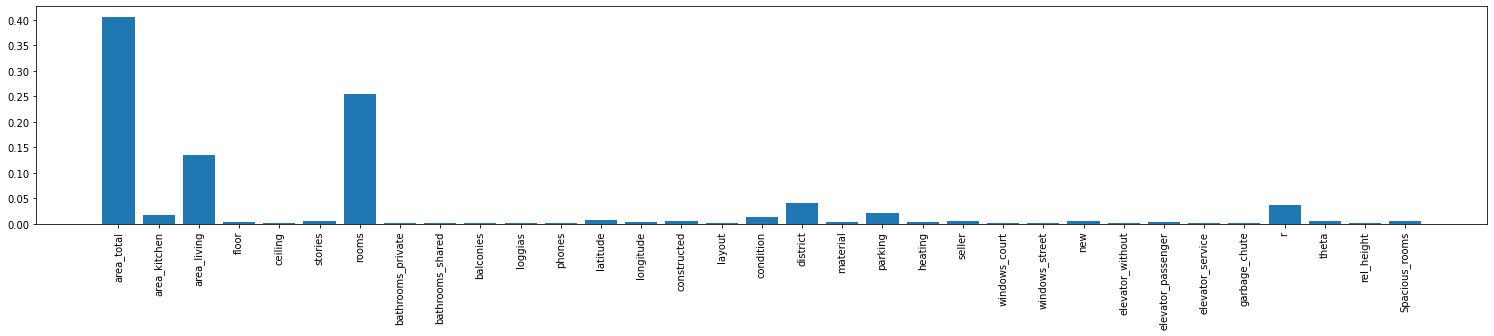

In [69]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [70]:
# Nan_model_1 uses only the common_mean=TRUE
# Nan_model_2 uses only the common_mean=FALSE
# Nan_model_3 uses common and also laure's method
# nan_model_4: move "constructed" to int-features. Got a liiiiitle better
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/nan_model_5", exponential=True)

# NEWER TECH

In [19]:
%run ../common_utils.py

In [32]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street"] #"address"] # Strings

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

In [33]:
# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test,
                                            features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=True, log_area=True, fillNan=True)  # False for XGBoost!

C:\School\høst 2021\TDT4173-ML\common_utils.py:1342: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_labels = train_labels.fillna(train_labels.median()) # Boolean
C:\School\høst 2021\TDT4173-ML\common_utils.py:1351: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_labels = test_labels.fillna(test_labels.median()) # Boolean


In [34]:
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    )

In [35]:
#f, ax = plt.subplots(figsize=(2, 12), dpi=100)
#heatmap = sns.heatmap(pd.merge(train_labels[added_features], train_targets,
#                              left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

In [36]:
# Normalize 
#NB! why not normalize integer features as well. Also remember new features...
#normalize_features = float_numerical_features + int_numerical_features + ["r", "theta", "spacious_rooms", "rel_living", "total_bathrooms", "rel_kitchen", "rel_height",
#                                                                          "dist_to_metro_m", "dist_to_hospital_m"]
    
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")

# One-hot encoding - not that good with XGBoost.
#train_labels, test_labels = one_hot_encoder(train_labels, test_labels, cat_features, drop_old=True)

minMax


In [37]:
droptable = ["street"]
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

In [38]:
model_params = [5, 12, 0.15, 0.8, 0.8, 1.1, 0.3, 0.01, 10000]
scores, avg, best_model, models = XGB_groupKFold(5, model_params, train_labels, train_targets,
    eval_metric='rmse')

In [39]:
print(scores)
print("=>",avg)

[0.21284180942752962, 0.17498083405023973, 0.20026156805107664, 0.18514938148086652, 0.2404937471682823]
=> 0.20274546803559898


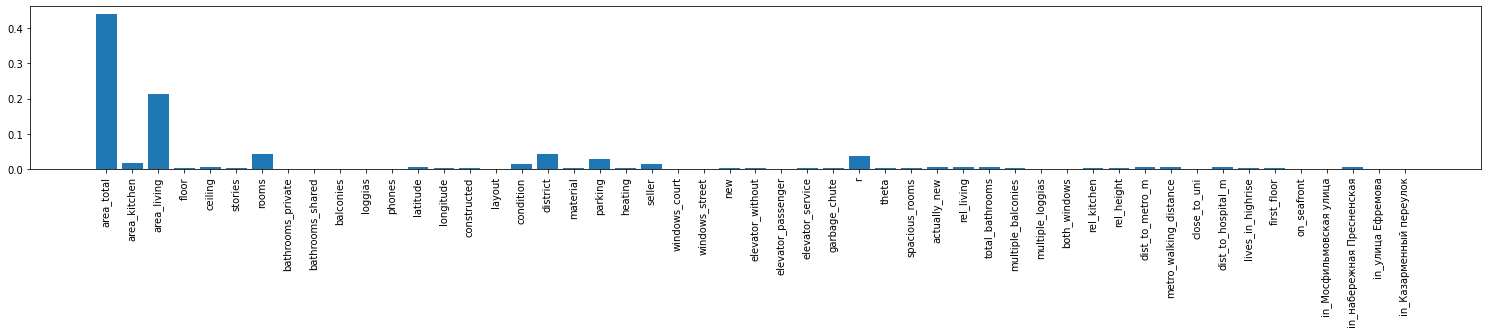

In [40]:
plt.figure(figsize=(26, 3))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [41]:
## brand_new_features_1 - all new features included. Logging everything. Not filling nans.: 0.177 on kaggle! Really good stuff.
## brand_new_features_2 - same, but also normalizing integer values, and new features: 0.18153 - ai, ai, ai!
#     => From feature importance: No obvious changes.
## brand_new_features_3 - back to 1, but also fillna()!: 

In [42]:
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/brand_new_features_3", exponential=True)
#for i in range(5):
#    predict_and_store(models[i], test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/new_features_"+str(i), exponential=True)

# TODO
- Multicoliinearity https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself
- Normalize integer values as well? Notice how important room was for the last model; rooms is not normalized!
- Get inspired? https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317

## Predict price/area instead of price!

Not logging price!
Needs a new Grouped_K_Fold

In [69]:
%run ../common_utils.py

In [75]:
# make sure all data is what we expect
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street"] #, "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = ["street"]

# Load data
train, test, metaData = load_all_data()
# Clean data. 
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=True, fillNan=False)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    )
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
#train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [77]:
price_per_square_meter = train_targets/train['area_total'] # real price / logged area

In [78]:
model_params = [5, 12, 0.15, 0.8, 0.8, 1.1, 0.3, 0.01, 10000]

In [79]:
scores, avg, best_model, models = XGB_groupKFold(5, model_params,
                                                 train_labels.drop(['area_total'],axis=1), np.log(price_per_square_meter),
                                                 eval_metric='rmse')


In [80]:
print(scores)
print("=>",avg)

[0.20252494570910018, 0.1719402910622423, 0.19194384452156768, 0.18187339676857273, 0.23624429647388234]
=> 0.19690535490707303


In [81]:
predict_and_store(best_model, test_labels.drop(["building_id", "area_total"], axis=1),
                  test, path="boosting_predictions/price_per_area_1", exponential=True,
                  price_per_sq=True, total_area_df=test_labels["area_total"])